In [45]:
"""
Testing memorization in VAR.

Settings: We have a subset of training data points (e.g., 5000 images from ImageNet train set).

1) mean activation of a neuron on a given training data point = expected activation of that neuron when the model is fed that data point multiple times with different augmentations.
2) 
"""

'\nTesting memorization in VAR.\n\nSettings: We have a subset of training data points (e.g., 5000 images from ImageNet train set).\n\n1) mean activation of a neuron on a given training data point = expected activation of that neuron when the model is fed that data point multiple times with different augmentations.\n2) \n'

In [3]:
import torch
import os
import sys
PROJECT_ROOT = os.path.abspath("../..")
sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)

import matplotlib.pyplot as plt
import numpy as np

Project root: /BS/scene_repre/work/VAR


In [9]:
unit_mem_file = PROJECT_ROOT + "/memorization/unitmem_scores_corrected.pt"
unit_mem_dict = torch.load(unit_mem_file)

In [10]:
print(unit_mem_dict.keys())  # Print the keys to see available layers

# total count of neurons
total_neurons = 0
for key in unit_mem_dict.keys():
    for block in range(len(unit_mem_dict[key])):
        for scale in range(10):
            C = unit_mem_dict[key][block][scale].shape[0]
            total_neurons += C

print("Total neurons across all layers:", total_neurons)

dict_keys(['fc1_act'])
Total neurons across all layers: 655360


In [11]:

all_unitmem = []  # list of (score, key, block, scale, unit)

# loop over keys "['fc1', 'fc1_act', 'fc2', 'q', 'k', 'v', 'attn_proj']" and 
# their corresponding values, which are lists of blocks. e.g. first iteration is: fc1, [block0, block1, ..., block15]
# second iteration is: fc1_act, [block0, block1, ..., block15], etc.
for key, blocks in unit_mem_dict.items():
    
    # Loop over blocks, e.g. block0, block1, ..., block15
    for block in range(len(blocks)):

        # Loop over scales, e.g. scale0, scale1, ..., scale9
        for scale in range(len(blocks[block])):
            unitmem_vec = blocks[block][scale]  # (C,)
            for unit in range(unitmem_vec.shape[0]):
                all_unitmem.append(
                    (unitmem_vec[unit].item(), key, block, scale, unit)
                )


In [12]:
def plot_unitmem_sum_heatmap(unit_mem_dict, layer, save_path=None):
    """
    Plot a heatmap showing the SUM of UnitMem scores per block and scale
    for a given layer (e.g. fc1).

    Parameters
    ----------
    unit_mem_dict : dict
        unit_mem_dict[layer][block][scale] -> Tensor (C,)
    layer : str
        Layer name to plot (e.g. "fc1")
    save_path : str or None
        If provided, saves the figure to this path
    """

    blocks = unit_mem_dict[layer]
    num_blocks = len(blocks)
    num_scales = len(blocks[0])

    # heatmap[b, s] = sum_u UnitMem(u) at (block=b, scale=s)
    heatmap = torch.zeros(num_blocks, num_scales)

    for b in range(num_blocks):
        for s in range(num_scales):
            unitmem_scores = blocks[b][s]     # (C,)
            heatmap[b, s] = unitmem_scores.sum()

    # convert to numpy for plotting
    heatmap = heatmap.cpu().numpy()

    # ---- Plot ----
    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        heatmap,
        origin="lower",      # block 0 at bottom
        aspect="auto",
        cmap="YlGnBu"
    )

    plt.colorbar(im, label="Sum of UnitMem scores")
    plt.xlabel("Scales")
    plt.ylabel("Blocks")
    #plt.title(f"Sum of UnitMem per block and scale ({layer})")

    plt.xticks(range(num_scales))
    plt.yticks(range(num_blocks))

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)

    plt.show()

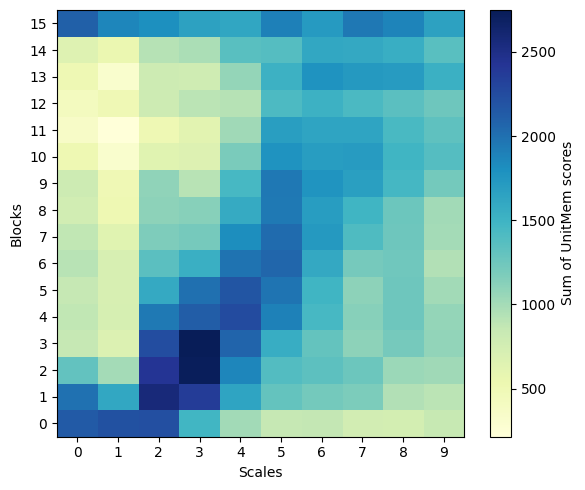

In [13]:
plot_unitmem_sum_heatmap(
    unit_mem_dict=unit_mem_dict,
    layer="fc1_act",
    save_path="unitmem_sum_fc1_act.png"
)